In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import dates
# from astropy.visualization import astropy_mpl_style
# plt.style.use(astropy_mpl_style)
import myRC
import sys
import astropy.units as u

from astropy.coordinates import SkyCoord, EarthLocation, AltAz

(5327448.9957829, -1718665.73869569, 3051566.90295403) m
4
nrows= 2 ncols= 2
[  0.  30.  60.  90. 120. 150. 180. 210. 240. 270. 300. 330. 360.] d
[<AxesSubplot:> <AxesSubplot:> <AxesSubplot:> <AxesSubplot:>]


<SkyCoord (AltAz: obstime=2022-02-11 06:00:00.000, location=(5327448.9957829, -1718665.73869569, 3051566.90295403) m, pressure=0.0 hPa, temperature=0.0 deg_C, relative_humidity=0.0, obswl=1.0 micron): (az, alt) in deg
    [(343.76996122, 24.78772832)]>

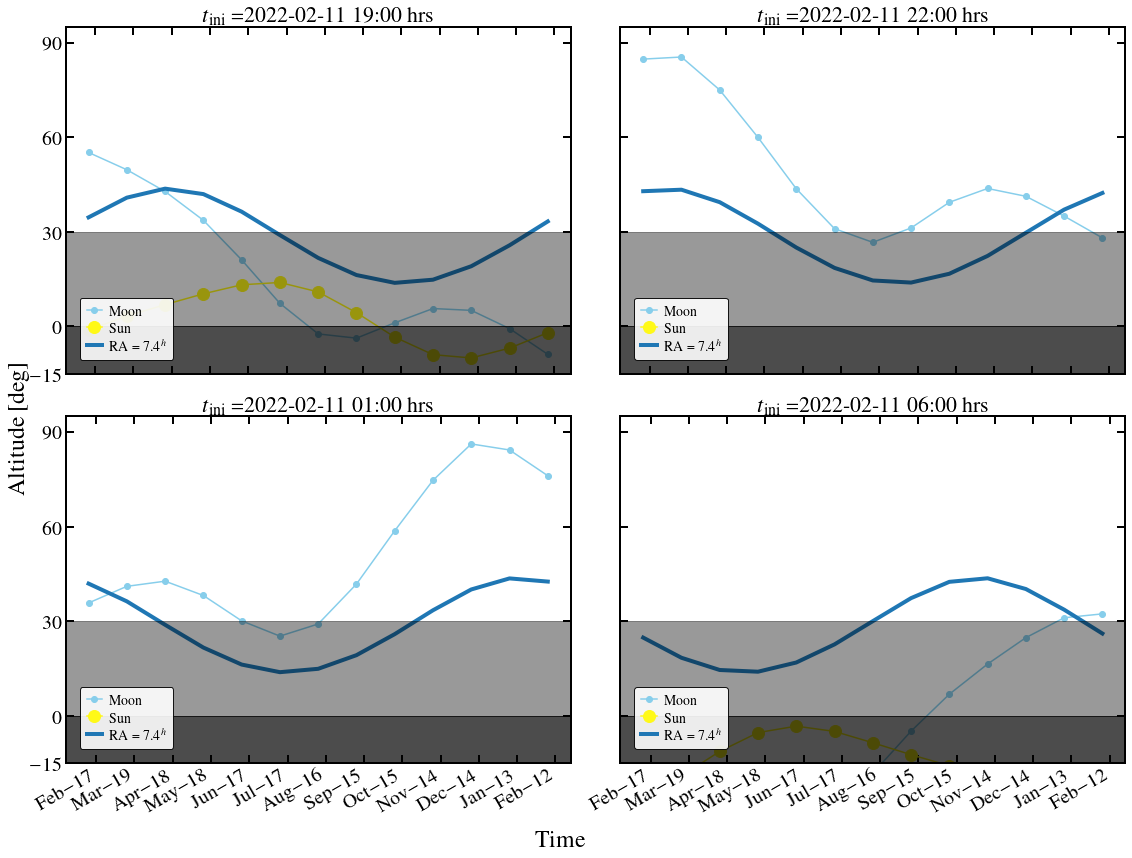

In [14]:
# RA = [0, 1, 2]
# DEC = [-10, -10, -10]

RA = ['07 24 32.29']
DEC = ['75 01 53.20']

# utcoffset = -4*u.hour  # Eastern Daylight Time
time1 = '2022-02-11 19:00:00'
time2 = '2022-02-11 22:00:00'
time3 = '2022-02-11 01:00:00'
time4 = '2022-02-11 06:00:00'
# time5 = '2021-12-23 07:00:00'
time = [time1, time2, time3, time4]
# time = [time3]

# print(EarthLocation.get_site_names())
# sys.exit()
ORM = EarthLocation.of_site('Roque de los Muchachos')#.to_geodetic()
LSO = EarthLocation.of_site('La Silla Observatory')#.to_geodetic()
print(ORM)

def trim_axs(axs, N):
    """little helper to massage the axs list to have correct length..."""
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]

def VTC(ra, dec, time0, location):
    '''Visibility Time Calculator'''
    from astropy.coordinates import get_sun, get_moon
    from astropy.time import Time
    # object_coords, obj_altaz = [], []
    # for ra, dec in zip(ra, dec):
    # print(time0)
    
    if len(time0) < 4:
        ncols=len(time0)
        nrows=1+len(time0)//ncols
    elif len(time0)==4:
        ncols=2
        nrows=2
    elif len(time0)>4 and len(time0)<7:
        ncols=3
        nrows=2
    
    print(len(time0))
    print('nrows=',nrows, 'ncols=', ncols)
    time_object = Time(time0)
    # print(time_object)
    ndays = 360
    step = 30
    # object_coords = SkyCoord(ra=RA*u.hourangle, dec=DEC*u.degree, frame='icrs')
    object_coords = SkyCoord(ra=RA, dec=DEC, unit=(u.hourangle, u.deg))
    if ndays < 2:
        delta_time = np.linspace(0, ndays, ndays*step)*u.hour
    else:
        delta_time = np.linspace(0, ndays, int(ndays/step)+1)*u.day
    print(delta_time)

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8*ncols, 6*nrows), sharey=True)
    if not all([nrows==1, ncols==1]):
        axes = trim_axs(axes, len(time0))
        # axes=axes.flatten()
    else:
        axes=[axes]
    print(axes)
    for ax, time in zip(axes, time_object):
    
    
        obj_altaz = object_coords.transform_to(AltAz(obstime=time,location=ORM))

        time_window = time+delta_time
        altaz_frame = AltAz(obstime=time_window, location=ORM)
        obj_altaz_frame = []
        for x in object_coords:
            obj_altaz_frame.append(x.transform_to(altaz_frame))


        sunaltazs_frame = get_sun(time_window).transform_to(altaz_frame)
        moonaltazs_frame = get_moon(time_window).transform_to(altaz_frame)
        t = Time(time_window, format='jyear', scale='utc')
        # print(moonaltazs_frame.alt)

        ax.plot_date(t.plot_date, moonaltazs_frame.alt, ls='-', ms=6, color='skyblue', label='Moon')
        ax.plot_date(t.plot_date, sunaltazs_frame.alt, ls='-', ms=12, color='xkcd:sunny yellow', label='Sun')
        for i,x in enumerate(obj_altaz_frame):
            ax.plot(t.plot_date, x.alt, '-', label=f'RA = {object_coords[i].ra.hour:.1f}$^h$', lw=4)
            # ax.scatter(t.plot_date, x.alt, c=x.az, label='Object 9 pm', lw=4, cmap='viridis')
        # axs = fig.gca()
        x_min, x_max = ax.get_xlim()
        # print(x_min, x_max)
        ax.fill_betweenx(np.linspace(0,30,100), x_min, x_max, color='k', alpha=0.4, zorder=3)
        ax.fill_betweenx(np.linspace(0,-25,100), x_min, x_max, color='k', alpha=0.7, zorder=3)
        # ax.colorbar().set_label('Azimuth [deg]')
        plt.gcf().autofmt_xdate()
        ax.set_title('$t_{\\rm ini} = $'+time.to_value('iso', subfmt='date_hm')+' hrs')
        ax.legend(loc='lower left', fontsize=14, framealpha=0.9)
        if ndays > 30:
            ax.xaxis.set_major_locator(dates.DayLocator(interval=30))
            ax.xaxis.set_major_formatter(dates.DateFormatter('%b-%d'))
        elif ndays < 7:
            ax.xaxis.set_major_locator(dates.HourLocator(interval=int(24/step)))
            ax.xaxis.set_major_formatter(dates.DateFormatter('%b-%d - %Hh'))        
            # ax.set_xticks(t.to_value('iso', subfmt='date_hm'))    
        ax.set_yticks([-15, 0, 30, 60, 90])
        ax.tick_params(axis='x', rotation=30)
        ax.set(xlim=(x_min, x_max), ylim=(-15, 95))#, xlabel=('Time'), ylabel=('Altitude [deg]'))
    # plt.setp(axes, xlim=(x_min, x_max))
    fig.supxlabel('Time', size=24)
    fig.supylabel('Altitude [deg]', size=24)
    plt.tight_layout()
    # plt.show()
    plt.savefig('visibility_curves.png')

    return obj_altaz
    # print(f"Objects's Altitude = {obj_altaz.alt:.4}")


    
    
    
    
    
# VTC(RA, DEC, time, LSO)
VTC(RA, DEC, time, ORM)
    







18980.425 19078.325


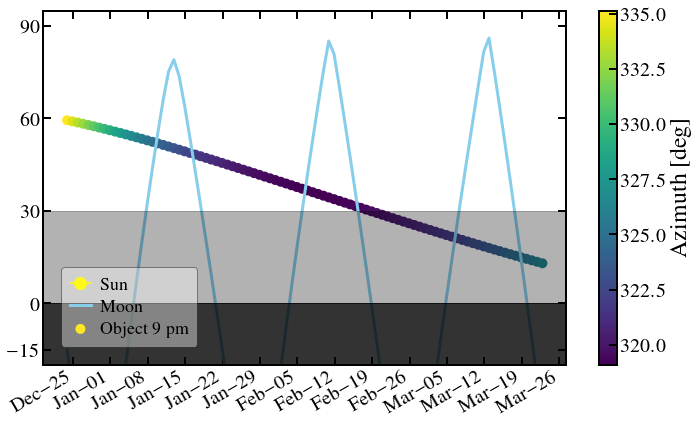

In [106]:
delta_time

In [9]:
#day
print('day: ', 57443-57046)
#night
print('night: ',36187-35889)

day:  397
night:  298


In [19]:
397*3.7

1468.9

In [20]:
298*3.7

1102.6000000000001

In [21]:
800/88

9.090909090909092